In [1]:
#emotion recognition in conversation (ERC) in hindi english code mixed conversation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import numpy as np
import pandas as pd
from torchtext import data
from torchtext import datasets
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

task1='/content/drive/MyDrive/Task 1/MaSaC_train_erc.json'

In [3]:
with open(task1, 'r') as file:
    data=json.load(file)
speakers = []
episodes = []
utterances = []
emotions = []
for i in data:
  speakers.append(i['speakers'])
  episodes.append(i['episode'])
  utterances.append(i['utterances'])
  emotions.append(i['emotions'])
# utterances[0]
emo = {'disgust': 1,
 'contempt': 2,
 'anger': 3,
 'neutral': 4,
 'joy': 5,
 'sadness': 6,
 'fear': 7,
 'surprise': 8}

In [4]:
print('no. of episodes : ',len(episodes))
print('no. of sentences : ',sum([len(x) for x in speakers]))

no. of episodes :  343
no. of sentences :  8506


In [5]:
emotion_cnts={}
for emotion_list in emotions:
  for emotion in emotion_list:
    if emotion not in  emotion_cnts:
      emotion_cnts[emotion]=1
    else:
      emotion_cnts[emotion]+=1
emotion_cnts

{'disgust': 127,
 'contempt': 542,
 'anger': 819,
 'neutral': 3909,
 'joy': 1596,
 'sadness': 558,
 'fear': 514,
 'surprise': 441}

In [6]:
class MyDataset:
    def __init__(self, data):
        self.data = data

    def __iter__(self):
        for item in self.data:
            yield item
data_list = []

for u,e in zip(utterances,emotions):
  for u1,e1 in zip(u,e):
    data_list.append((emo[e1],u1))

my_dataset = MyDataset(data_list)
random.shuffle(data_list)
split_ratio = 0.8
split_index = int(len(data_list) * split_ratio)
print(split_index)
train_data = data_list[:split_index]
test_data = data_list[split_index:]
train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)
complete_dataset = MyDataset(data_list)

6804


In [7]:
tokenizer = get_tokenizer("basic_english")
train_iter = train_dataset

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_iter = train_dataset
dataloader = DataLoader(
    train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch
)

In [10]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes,in_channels,):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.conv_layer1 = nn.Conv1d(in_channels, 64, kernel_size=3)
        self.conv_layer2 = nn.Conv1d(64, 128, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(7936 , 128)  # Adjust input size based on conv layer output
        self.fc2 = nn.Linear(128, num_classes)


    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = embedded.unsqueeze(dim=1)
        # print(embedded.shape)
        x = self.conv_layer1(embedded)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv_layer2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
# class TextClassificationModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, num_class):
#         super(TextClassificationModel, self).__init__()
#         self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
#         self.fc = nn.Linear(embed_dim, int(embed_dim/2))
#         self.dropout = nn.Dropout(p=0.3)
#         self.fc1 = nn.Linear(int(embed_dim/2),num_class)
#         self.init_weights()

#     def init_weights(self):
#         initrange = 0.5
#         self.embedding.weight.data.uniform_(-initrange, initrange)
#         self.fc.weight.data.uniform_(-initrange, initrange)
#         self.fc.bias.data.zero_()
#         self.fc1.weight.data.uniform_(-initrange, initrange)
#         self.fc1.bias.data.zero_()

#     def forward(self, text, offsets):
#         embedded = self.embedding(text, offsets)
#         fc=self.fc(embedded)
#         fc=self.dropout(fc)
#         fc1=self.fc1(fc)
#         return fc1

In [11]:
train_iter = train_dataset
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 256
model = TextClassificationModel(vocab_size, emsize, num_class,1).to(device)


In [12]:

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    pred_labels = []
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            pred_labels.append(predicted_label.argmax(1))
            total_count += label.size(0)
    return total_acc / total_count,pred_labels

In [13]:
EPOCHS = 20  # epoch
LR = 1# learning rate
BATCH_SIZE = 8  # batch size for training
labels = []
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = train_dataset,test_dataset
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
complete_dataset =to_map_style_dataset(complete_dataset)

# num_train = int(len(train_dataset) * 0.95)
# split_train_, split_valid_ = random_split(
#     train_dataset, [num_train, len(train_dataset) - num_train]
# )
# print(split_train_)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
# valid_dataloader = DataLoader(
#     split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
# )
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
complete_dataloader = DataLoader(
    complete_dataset,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_batch
)
for x,y,z in test_dataloader:
  labels.append(x)



for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val,_ = evaluate(test_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)

| epoch   1 |   500/  851 batches | accuracy    0.469
-----------------------------------------------------------
| end of epoch   1 | time: 16.41s | valid accuracy    0.416 
-----------------------------------------------------------
| epoch   2 |   500/  851 batches | accuracy    0.469
-----------------------------------------------------------
| end of epoch   2 | time: 15.70s | valid accuracy    0.426 
-----------------------------------------------------------
| epoch   3 |   500/  851 batches | accuracy    0.476
-----------------------------------------------------------
| end of epoch   3 | time: 15.36s | valid accuracy    0.427 
-----------------------------------------------------------
| epoch   4 |   500/  851 batches | accuracy    0.488
-----------------------------------------------------------
| end of epoch   4 | time: 14.88s | valid accuracy    0.429 
-----------------------------------------------------------
| epoch   5 |   500/  851 batches | accuracy    0.514
------

In [14]:
_,y_pred=evaluate(test_dataloader)

In [15]:
pred = []
true = []
for x,y in zip(y_pred,labels):
  for l in x:
    pred.append(l)
  for l in y:
    true.append(l)


In [16]:

classification_report(pred,true)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       0.00      0.00      0.00         3\n           2       0.02      0.12      0.03        24\n           3       0.82      0.41      0.55      1401\n           4       0.12      0.21      0.15       205\n           5       0.02      0.14      0.03        14\n           6       0.01      0.07      0.02        15\n           7       0.00      0.00      0.00        40\n\n    accuracy                           0.37      1702\n   macro avg       0.12      0.12      0.10      1702\nweighted avg       0.69      0.37      0.47      1702\n'

In [17]:
# true

In [18]:
with open('c.txt','w') as report:
  report.write(classification_report(pred,true))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

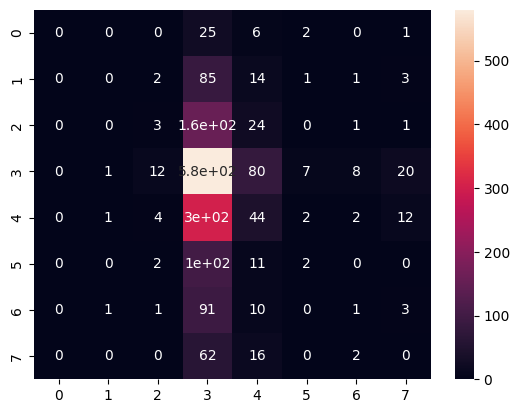

In [19]:
confusion_matrix(true, pred)
import seaborn as sns
sns.heatmap(confusion_matrix(true,pred), annot=True)

In [20]:
import pandas as pd
import numpy as np

# Sample confusion matrix (3x3) with numerical labels (0, 1, 2)
confusion_matrix = confusion_matrix(true,pred)

# Define custom class labels
class_labels = ["disgust", "contempt", "anger","neutral","joy","sadness","fear","surprise"]

# Create a DataFrame with custom labels
confusion_df = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

# Print the confusion matrix with custom class labels
print(confusion_df)


          disgust  contempt  anger  neutral  joy  sadness  fear  surprise
disgust         0         0      0       25    6        2     0         1
contempt        0         0      2       85   14        1     1         3
anger           0         0      3      156   24        0     1         1
neutral         0         1     12      580   80        7     8        20
joy             0         1      4      302   44        2     2        12
sadness         0         0      2      100   11        2     0         0
fear            0         1      1       91   10        0     1         3
surprise        0         0      0       62   16        0     2         0
